In [ ]:
#!pip install --upgrade tensorflow
!pip install --upgrade tensorflow
!pip install --upgrade keras
!pip install --upgrade wandb

  Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
Using cached tensorflow-2.18.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (615.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


How can individual player behaviors (pass routes) be predicted to enhance strategic planning?



## Import and Load

In [3]:
import pandas as pd
import numpy as np

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split, DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers,ops, losses, metrics, optimizers, Sequential
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, SimpleRNN, Reshape, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_accuracy, categorical_crossentropy, F1Score, Precision, Recall, CategoricalAccuracy, BinaryAccuracy, Accuracy
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight


import matplotlib.pyplot as plt

import wandb
from wandb.integration.keras import WandbCallback, WandbMetricsLogger,WandbModelCheckpoint, WandbEvalCallback

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
play_path = '/content/drive/Shareddrives/461 Project/nfl-big-data-bowl-2025/plays.csv'
play_play_path = '/content/drive/Shareddrives/461 Project/nfl-big-data-bowl-2025/player_play.csv'

In [6]:
# Load the datasets
play_data = pd.read_csv(play_path)
player_play_data = pd.read_csv(play_play_path)

# Display dataset shapes
print(f"Play Data: {play_data.shape}")
print(f"Player Play Data: {player_play_data.shape}")

Play Data: (16124, 50)
Player Play Data: (354727, 50)


In [7]:
player_play_data['routeRan'].value_counts()

,count
routeRan,
GO,7806
HITCH,6296
FLAT,6208
OUT,4293
CROSS,4219
IN,3373
POST,2701
SLANT,2295
CORNER,1841


([<matplotlib.patches.Wedge at 0x7ad54d67c670>,
 [Text(0.924154069976487, 0.5966064489643862, 'GO'),
  Text(-0.041875063613715235, 1.09920265604089, 'HITCH'),
  Text(-0.8987974997858907, 0.6341632710734926, 'FLAT'),
  Text(-1.086519651795228, -0.1716829818670929, 'OUT'),
  Text(-0.7805970966291947, -0.7750278528763156, 'CROSS'),
  Text(-0.2523162074809446, -1.0706710659406244, 'IN'),
  Text(0.234275697131656, -1.0747627169442922, 'POST'),
  Text(0.6042211452053342, -0.919193563775745, 'SLANT'),
  Text(0.8514841834521568, -0.6964012387487647, 'CORNER'),
  Text(1.0052895254057506, -0.44653439969332803, 'SCREEN'),
  Text(1.0861259923439996, -0.1741560471380834, 'ANGLE'),
  Text(1.099856438693695, -0.01777116383420653, 'WHEEL')])

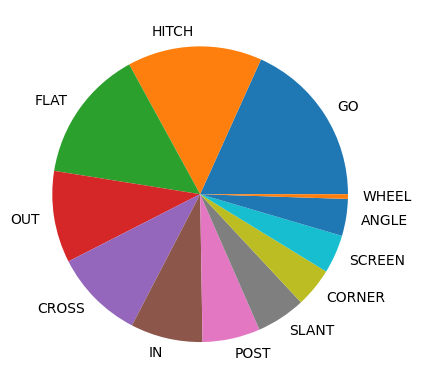

In [8]:
# create pie chart of pff_manZone
plt.pie(player_play_data['routeRan'].value_counts(), labels=player_play_data['routeRan'].value_counts().index)

## Data Cleaning

### Split Game Clock to minutes and seconds columns so can be read as an integer

In [9]:
# convert gameClock to string
play_data['gameClock'] = play_data['gameClock'].astype(str)

# split gameClock by : (original format = MM:SS)
play_data[['gameMin','gameSec']] = play_data['gameClock'].str.split(':', n=1, expand=True)

# Drop the original 'gameClock' column not needed
play_data = play_data.drop('gameClock', axis=1)

# convert gameMin and gameSec to int so more easily interpreted
play_data['gameMin'] = play_data['gameMin'].astype(int)
play_data['gameSec'] = play_data['gameSec'].astype(int)

### Define important features for each dataset

In [10]:
# Features from play_data
play_features = [
    'gameId', 'playId',                 # Identifiers
    'quarter', 'down', 'yardsToGo',     # Game situation
    'possessionTeam', 'defensiveTeam',  # Teams involved
    'gameMin', 'gameSec',
    'yardlineSide', 'yardlineNumber',
    'preSnapHomeScore', 'preSnapVisitorScore',
    'absoluteYardlineNumber',
    'preSnapHomeTeamWinProbability',
    'preSnapVisitorTeamWinProbability',
    'expectedPoints',                   # Score and position context
    'offenseFormation',
    'receiverAlignment',
    'playAction', 'isDropback',         # Formation and play type
    'passResult', 'passLength',
    'rushLocationType', 'yardsGained',  # Passing and rushing context
    'timeToThrow', 'timeInTackleBox',   # Advanced metrics
    'pff_runConceptPrimary',
    'pff_runPassOption',
    'pff_passCoverage', 'pff_manZone'   # Strategy and coverage
]

# Features from player_play_data
player_play_features = [
    'gameId', 'playId', 'nflId', 'teamAbbr',          # Identifiers
    'hadRushAttempt', 'rushingYards',                # Rushing behavior
    'hadDropback', 'passingYards',                   # Passing behavior
    'hadPassReception', 'receivingYards',
    'wasTargettedReceiver', 'yardageGainedAfterTheCatch',  # Receiving behavior
    'soloTackle', 'assistedTackle',
    'tackleForALoss', 'tackleForALossYardage',       # Tackling
    'forcedFumbleAsDefense',                         # Defensive plays
    'wasInitialPassRusher', 'causedPressure',
    'pressureAllowedAsBlocker',
    'timeToPressureAllowedAsBlocker',                # Blocking and pressure
    'wasRunningRoute', 'routeRan',
    'pff_defensiveCoverageAssignment',
    'pff_primaryDefensiveCoverageMatchupNflId'      # Routes and coverage
]

feature_columns = play_features + player_play_features

### Drop unimportant columns



In [11]:
# Drop columns not relevant to predicting individual player behaviors
play_data = play_data[play_features]
player_play_data = player_play_data[player_play_features]

# Display dataset shapes after dropping columns
print(f"Play Data: {play_data.shape}")
print(f"Player Play Data: {player_play_data.shape}")

Play Data: (16124, 31)
Player Play Data: (354727, 25)


### Combine the datasets on the identifiers 'gameId' and 'playId'

In [12]:
combined_data = pd.merge(play_data, player_play_data, on=['gameId', 'playId'], how='inner')
print(f"Combined Data: {combined_data.shape}")

Combined Data: (354727, 54)


## Preprocessing

### Categorical Preprocessing

In [13]:
def preprocess_categorical_data(df):
  # Select categorical columns
  cat_cols = df.select_dtypes(include=['object']).columns
  # Make nan for categorical = 'missing'
  for column in df.select_dtypes(include=['object']):
    df[column] = df[column].fillna('missing')
  # Convert object to string
  for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype(str)
  # Get categorical column names
  categorical_feature_names = np.asarray(cat_cols)
  return df, categorical_feature_names

### Numeric Preprocessing

In [14]:
def preprocess_numeric_data(df):
  # Select numeric columns
  num_cols = df.select_dtypes(include=['int64', 'float64']).columns
  # Make nan for numeric = 0
  for column in df.select_dtypes(include=['int64', 'float64']):
    df[column] = df[column].fillna(0)
  # Convert numeric to float
  for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col] = df[col].astype(float)  # Convert to float
  # Get numeric column names
  numeric_feature_names = np.asarray(num_cols)
  return df, numeric_feature_names

### Binary Preprocessing

In [15]:
def preprocess_binary_data(df):
  # Select binary columns
  binary_cols = df.select_dtypes(include=['bool']).columns
  # Convert binary from bool to int
  for col in df.select_dtypes(include=['bool']).columns:
    df[col] = df[col].astype(int)  # Convert True to 1, False to 0
  # Get binary column names
  binary_feature_names = np.asarray(binary_cols)
  return df, binary_feature_names

### Convert Categorical values string and send to inputs


In [16]:
def categorical_input(df,inputs):
  # Convert categorical values to TensorFlow string
  for name, column in df.items():
    if (name in categorical_feature_names):
      dtype = tf.string
    # Convert rest to TensorFrflow float
    else:
      dtype = tf.float32
    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)
  return inputs

### Categorical Feature names to preprocesed


In [17]:
def categorical_features(categorical_feature_names, df, inputs, preprocessed):
  for name in categorical_feature_names:
    # get different category names for each feature
    vocab = sorted(set(str(x) for x in df[name]))
    print(f'name: {name}')
    print(f'vocab: {vocab}\n')
    # Onehot encode category names to convert to numeric if string
    if type(vocab[0]) is str:
      lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
    # If not string convert to string then one hot encode
    else:
      inputs[vocab] = tf.strings.as_string(inputs[vocab])
      lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')
    # add to preprocessed list
    x = inputs[name]
    x = lookup(x)
    preprocessed.append(x)

  return preprocessed

### Binary Feature names to preprocessed

In [18]:
def binary_features(binary_feature_names, inputs, preprocessed):
  # Since binary features were already converted to numeric then float we can just add to input list
  for name in binary_feature_names:
    inp = inputs[name]
    preprocessed.append(inp)
  return preprocessed

### Numeric Features to preprocessed

In [19]:
def numeric_features(numeric_feature_names, df, inputs, preprocessed):
  # get numeric features from dataframe
  num_features = df[numeric_feature_names]
  # convert from numpy to tensor
  tf.convert_to_tensor(num_features)
  # use indicies to avoid data mismatching
  num_features_dict = {key: value.to_numpy()[:, tf.newaxis] for key, value in dict(num_features).items()}
  # modify target axis to TensorFlow axis
  target_array =  target[:, tf.newaxis]

  # Normalize the data
  normalizer = tf.keras.layers.Normalization(axis=-1)
  normalizer.adapt(np.concatenate([value for key, value in sorted(num_features_dict.items())], axis=1))

  # create empty list of numeric inputs then populate
  numeric_inputs = []
  for name in numeric_feature_names:
    numeric_inputs.append(inputs[name])

  # make sure all numeric inputs are stored in the list
  numeric_inputs = tf.keras.layers.Concatenate(axis=-1)(numeric_inputs)
  # normalize again
  numeric_normalized = normalizer(numeric_inputs)
  # add numeric to preprocessed
  preprocessed.append(numeric_normalized)

  return preprocessed

### Concatenate Preprocessed data

In [20]:
def concat_prepro(preprocessed, inputs):
  # Concatenate preprocessed data across data types
  preprocessed_result = tf.keras.layers.Concatenate(axis=1)(preprocessed)
  print(preprocessed_result)
  # Create preprocesssing model
  preprocessor = tf.keras.Model(inputs, preprocessed_result)
  print(preprocessor)
  # plot the model
  model_plot = tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True,  show_layer_names=True)
  return preprocessor, model_plot

### Set target variables and encode 'routeRan' as it is a categorical feature

In [21]:
target = combined_data.pop('routeRan')
onehot_encoder = OneHotEncoder(sparse_output=False)
target = onehot_encoder.fit_transform(target.values.reshape(-1, 1))

In [22]:
X = combined_data
y = target

### Split into training, testing, and validation sets

In [23]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## Implement preprocessing

In [24]:
inputs = {}
preprocessed = []

### Preprocess Categorical data

#### Train

In [25]:
train_inputs = {}
train_preprocessed = []

In [26]:
X_train, categorical_feature_names = preprocess_categorical_data(X_train)

In [27]:
train_inputs = categorical_input(X_train, train_inputs)
train_inputs

{'gameId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameId>,
 'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'gameMin': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameMin>,
 'gameSec': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameSec>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHome

In [28]:
train_preprocessed = categorical_features(categorical_feature_names, X_train, train_inputs, train_preprocessed)
train_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT', 'missing']

name: receiverAlignment
vocab: ['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3', '4x1', '4x2', 'missing']

name: passResult

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_11>]

#### Validation

In [29]:
val_inputs = {}
val_preprocessed = []

In [30]:
X_val, categorical_feature_names = preprocess_categorical_data(X_val)

In [31]:
val_inputs = categorical_input(X_val, val_inputs)
val_inputs

{'gameId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameId>,
 'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'gameMin': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameMin>,
 'gameSec': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameSec>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHome

In [32]:
val_preprocessed = categorical_features(categorical_feature_names, X_val, val_inputs, val_preprocessed)
val_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT', 'missing']

name: receiverAlignment
vocab: ['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3', '4x1', '4x2', 'missing']

name: passResult

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_12>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_13>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_14>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_2

#### Test

In [33]:
test_inputs = {}
test_preprocessed = []

In [34]:
X_test, categorical_feature_names = preprocess_categorical_data(X_test)

In [35]:
test_inputs = categorical_input(X_test, test_inputs)
test_inputs

{'gameId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameId>,
 'playId': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=playId>,
 'quarter': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=quarter>,
 'down': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=down>,
 'yardsToGo': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardsToGo>,
 'possessionTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=possessionTeam>,
 'defensiveTeam': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=defensiveTeam>,
 'gameMin': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameMin>,
 'gameSec': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=gameSec>,
 'yardlineSide': <KerasTensor shape=(None, 1), dtype=string, sparse=False, name=yardlineSide>,
 'yardlineNumber': <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=yardlineNumber>,
 'preSnapHome

In [36]:
test_preprocessed = categorical_features(categorical_feature_names, X_test, test_inputs, test_preprocessed)
test_preprocessed

name: possessionTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: defensiveTeam
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS']

name: yardlineSide
vocab: ['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL', 'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX', 'KC', 'LA', 'LAC', 'LV', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'PHI', 'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS', 'missing']

name: offenseFormation
vocab: ['EMPTY', 'I_FORM', 'JUMBO', 'PISTOL', 'SHOTGUN', 'SINGLEBACK', 'WILDCAT', 'missing']

name: receiverAlignment
vocab: ['1x0', '1x1', '2x0', '2x1', '2x2', '3x0', '3x1', '3x2', '3x3', '4x1', '4x2', 'missing']

name: passResult

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_27>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_28>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_29>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_3

### Preprocess Binary Data

#### Train

In [37]:
X_train, binary_feature_names = preprocess_binary_data(X_train)

In [38]:
train_preprocessed = binary_features(binary_feature_names, train_inputs, train_preprocessed)
train_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasT

#### Validation

In [39]:
X_val, binary_feature_names = preprocess_binary_data(X_val)

In [40]:
val_preprocessed = binary_features(binary_feature_names, val_inputs, val_preprocessed)
val_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_12>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_13>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_14>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_2

#### Test

In [41]:
X_test, binary_feature_names = preprocess_binary_data(X_test)

In [42]:
test_preprocessed = binary_features(binary_feature_names, test_inputs, test_preprocessed)
test_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_27>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_28>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_29>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_3

### Preprocess Numeric Data

#### Train

In [43]:
X_train, numeric_feature_names = preprocess_numeric_data(X_train)

In [44]:
train_preprocessed = numeric_features(numeric_feature_names, X_train, train_inputs, train_preprocessed)
train_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_2>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_4>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_8>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_10>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasT

#### Validation

In [45]:
X_val, numeric_feature_names = preprocess_numeric_data(X_val)

In [46]:
val_preprocessed = numeric_features(numeric_feature_names, X_val, val_inputs, val_preprocessed)
val_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_12>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_13>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_14>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_16>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_18>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_2

#### Test

In [47]:
X_test, numeric_feature_names = preprocess_numeric_data(X_test)

In [48]:
test_preprocessed = numeric_features(numeric_feature_names, X_test, test_inputs, test_preprocessed)
test_preprocessed

[<KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_25>,
 <KerasTensor shape=(None, 34), dtype=float32, sparse=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, 9), dtype=float32, sparse=False, name=keras_tensor_27>,
 <KerasTensor shape=(None, 13), dtype=float32, sparse=False, name=keras_tensor_28>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_29>,
 <KerasTensor shape=(None, 7), dtype=float32, sparse=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 14), dtype=float32, sparse=False, name=keras_tensor_31>,
 <KerasTensor shape=(None, 20), dtype=float32, sparse=False, name=keras_tensor_32>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_33>,
 <KerasTensor shape=(None, 33), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 21), dtype=float32, sparse=False, name=keras_tensor_3

### Concatenate Preprocessed tensors and show model plot

#### Train

In [49]:
train_preprocessor, train_model_plot = concat_prepro(train_preprocessed, train_inputs)

<KerasTensor shape=(None, 273), dtype=float32, sparse=False, name=keras_tensor_42>
<Functional name=functional, built=True>


#### Validation

In [50]:
val_preprocessor, val_model_plot = concat_prepro(val_preprocessed, val_inputs)

<KerasTensor shape=(None, 273), dtype=float32, sparse=False, name=keras_tensor_43>
<Functional name=functional_1, built=True>


#### Test

In [51]:
test_preprocessor, test_model_plot = concat_prepro(test_preprocessed, test_inputs)
test_model_plot

<KerasTensor shape=(None, 273), dtype=float32, sparse=False, name=keras_tensor_44>
<Functional name=functional_2, built=True>


In [52]:
X_train_pretensor = train_preprocessor(dict(X_train))

In [53]:
X_val_pretensor = val_preprocessor(dict(X_val))

In [54]:
X_test_pretensor = test_preprocessor(dict(X_test))

## Create Keras Model

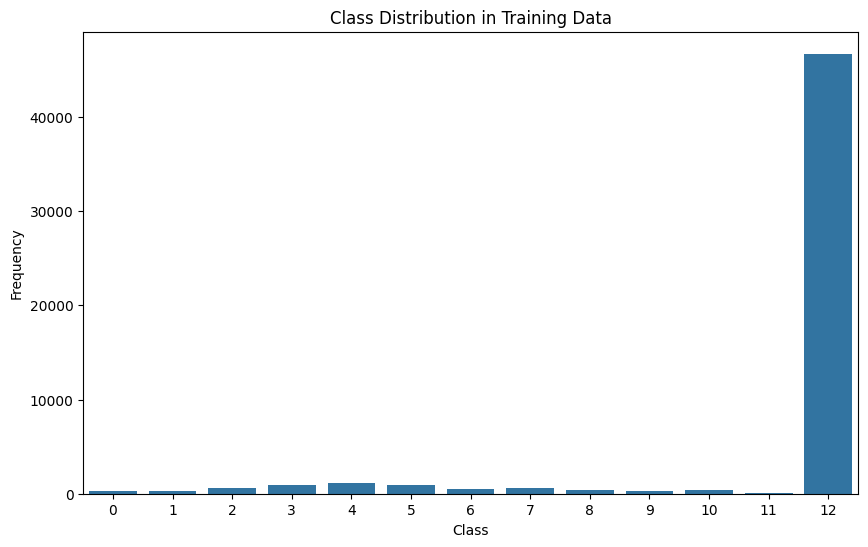

In [ ]:
# prompt: plot the the final preprocessed data to show how balanced it is

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'y_train' is your target variable after one-hot encoding
# Calculate class frequencies
class_counts = np.sum(y_val, axis=0)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=np.arange(len(class_counts)), y=class_counts)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Distribution in Training Data")
plt.show()

In [ ]:
import wandb
from wandb.integration.keras import WandbMetricsLogger

# Initialize a new W&B run
run = wandb.init(project = "Predicting Routes Run",
                 config={
    "learning_rate": 1e-3,
    "loss_function": "categorical_crossentropy",
    "architecture": "CNN",
    "batch_size": 128,
    "n_epochs": 5
    })
config = wandb.config

optimizer = tf.keras.optimizers.Adam(config.learning_rate)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### HyperParameter Sweep

In [ ]:
sweep_config = {
    'method': 'grid'
}

metric =  {
        'name': 'f1_score',
        'goal': 'maximize'
    }


sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'epochs': {
        'values': [1]
        },
    'learning_rate': {
        'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
    'batch_size': {
        'values': [256, 128, 64, 32]
        },
    'simple_rnn_size': {
        'values': [64, 128, 256]
        },
    'fc_layer_size': {
        'values': [128, 256]
        },
    'conv_layer_size': {
        'values': [32, 64, 128]
        },
    'conv_strides': {
        'values': [1, 2]
        },
    'max_pool_size': {
        'values': [2, 4]
        },
    'max_pool_strides': {
        'values': [2, 4]
        },
    'max_pool_padding': {
        'values': ['same', 'valid']
        },
    'dropout': {
          'values': [0.2, 0.5]
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="Predicting Routes Run")

Create sweep with ID: zddnfc84
Sweep URL: https://wandb.ai/nlichtenfels-university-of-rhode-island/Predicting%20Routes%20Run/sweeps/zddnfc84


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 5,
        'batch_size': 128,
        'weight_decay': 0.0005,
        'learning_rate': 1e-3,
        'activation': 'relu',
        'optimizer': 'adam',
        'hidden_layer_size': 128,
        'conv_layer_size': 16,
        'conv_strides': 1,
        'max_pool_size': 2,
        'max_pool_strides': 2,
        'max_pool_padding': 'same',
        'simple_rnn_size': 128,
        'dropout': 0.5,
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)

    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
# define model
    model1 = keras.Sequential([
    keras.Input(shape=(None, 1)),
    keras.layers.SimpleRNN(config.simple_rnn_size,activation = "tanh"),
    keras.layers.Reshape((-1, 1) ),
    keras.layers.Conv1D(config.conv_layer_size, config.conv_strides, activation='relu'),
    keras.layers.MaxPooling1D(config.max_pool_size, config.max_pool_strides, config.max_pool_padding),
    keras.layers.Dropout(config.dropout),
    keras.layers.Conv1D(config.conv_layer_size, config.conv_strides, activation='relu'),
    keras.layers.MaxPooling1D(config.max_pool_size, config.max_pool_strides, config.max_pool_padding),
    keras.layers.Flatten(),
    keras.layers.Dense(config.hidden_layer_size, activation="relu"),
    keras.layers.Dropout(config.dropout),
    keras.layers.Dense(config.hidden_layer_size, activation="relu"),
    keras.layers.Dense(3, activation="softmax")

    ])

        # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate = config.learning_rate)

    model1.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics=['f1_score'])

    model1.fit(X_train_pretensor, y_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_pretensor, y_val),
              callbacks=[WandbCallback(validation_data=(X_val_pretensor, y_val)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ac8786f6800>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ac8786f6800>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
# Initialize a new sweep
# Arguments:
#     – sweep_id: the sweep_id to run - this was returned above by wandb.sweep()
#     – function: function that defines your model architecture and trains it
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Ctrl + C detected. Stopping sweep.


Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7ac8786f6800>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

### CNN Model

In [55]:
shuffle_buffer = 500
batch_size = 256
n_epochs = 5

In [56]:
model1 = keras.Sequential([
    keras.Input(shape=(None, 1)),
    keras.layers.SimpleRNN(256,activation = "tanh"),
    keras.layers.Reshape((-1, 1) ),
    keras.layers.Conv1D(128, 4, activation='relu'),
    keras.layers.MaxPooling1D(4, 2),
    keras.layers.Dropout(.5),
    keras.layers.Conv1D(64, 2, activation='relu'),
    keras.layers.MaxPooling1D(2, 1),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(13, activation="softmax")

])

In [57]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 256)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 256, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 253, 128)            │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 124, 64)             │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,007,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,099,981 (4.20 MB)

 Trainable params: 1,099,981 (4.20 MB)

 Non-trainable params: 0 (0.00 B)

#### LR = 1e-2

In [ ]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=config.loss_function,
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 256, lr = 1e-2, original data

In [ ]:
m1_ori_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      #class_weight = class_weight_dict
      callbacks=[WandbMetricsLogger()]
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1269s 1s/step - categorical_accuracy: 0.8735 - f1_score: 0.0728 - loss: 0.6089 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6434
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - categorical_accuracy: 0.8791 - f1_score: 0.0787 - loss: 0.5080 - val_categorical_accuracy: 0.8816 - val_f1_score: 0.0866 - val_loss: 0.5486
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1280s 1s/step - categorical_accuracy: 0.8822 - f1_score: 0.0925 - loss: 0.5457 - val_categorical_accuracy: 0.8817 - val_f1_score: 0.0867 - val_loss: 0.5426
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1252s 1s/step - categorical_accuracy: 0.8827 - f1_score: 0.0919 - loss: 0.5379 - val_categorical_accuracy: 0.8780 - val_f1_score: 0.0727 - val_loss: 0.5309
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1274s 1s/step - categorical_accuracy: 0.8784 - f1_score: 0.0798 - loss: 0.6085 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6758


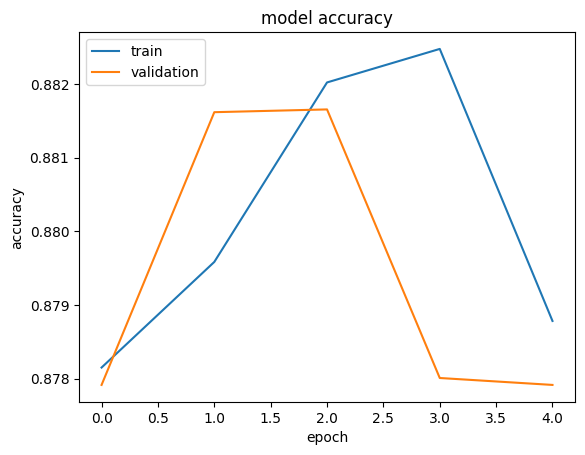

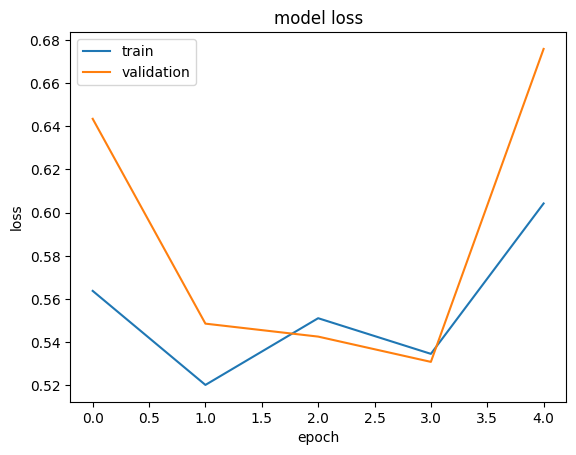

In [ ]:
#  "Accuracy"
plt.plot(m1_ori_his.history['categorical_accuracy'])
plt.plot(m1_ori_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_ori_his.history['loss'])
plt.plot(m1_ori_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 1 batch = 128, lr = 1e-2, original data

In [ ]:
m1_b128_lr2 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      #class_weight = class_weight_dict
      callbacks=[WandbMetricsLogger()]
    )

Epoch 1/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 1538s 793ms/step - categorical_accuracy: 0.8790 - f1_score: 0.0726 - loss: 0.5948 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.7074
Epoch 2/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 1527s 787ms/step - categorical_accuracy: 0.8793 - f1_score: 0.0720 - loss: 0.6292 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6342
Epoch 3/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 1533s 790ms/step - categorical_accuracy: 0.8795 - f1_score: 0.0720 - loss: 0.6272 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6340
Epoch 4/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 1569s 783ms/step - categorical_accuracy: 0.8813 - f1_score: 0.0721 - loss: 0.6197 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6338
Epoch 5/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 1510s 777ms/step - categorical_accuracy: 0.8805 - f1_score: 0.0720 - loss: 0.6229 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6340


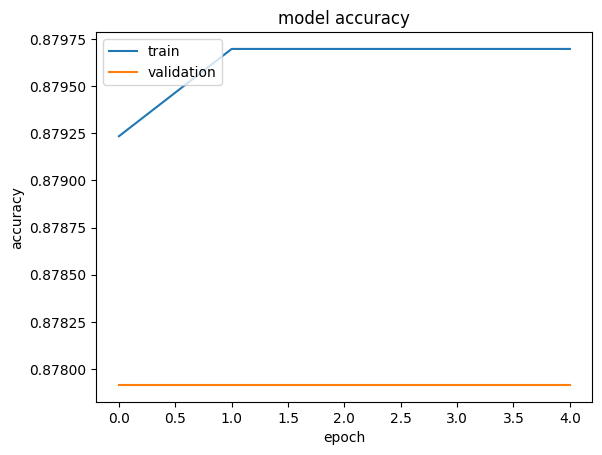

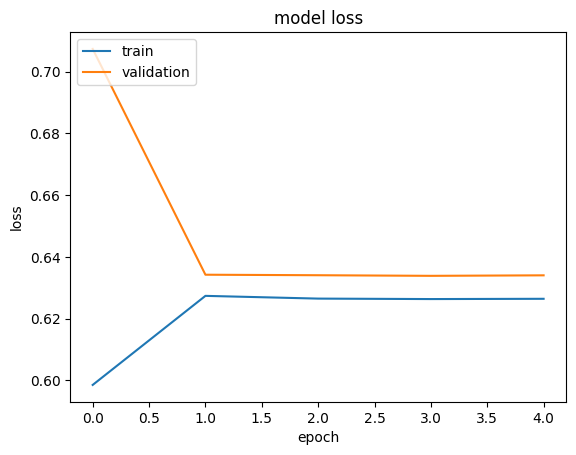

In [ ]:
#  "Accuracy"
plt.plot(m1_b128_lr2.history['categorical_accuracy'])
plt.plot(m1_b128_lr2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_b128_lr2.history['loss'])
plt.plot(m1_b128_lr2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### LR = 1e-3

In [58]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 256, lr = 1e-3, original data

In [59]:
m1_b256_lr3 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 256,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - categorical_accuracy: 0.8735 - f1: 0.0788 - loss: 0.6179 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6732
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 71s 48ms/step - categorical_accuracy: 0.8799 - f1: 0.0720 - loss: 0.5693 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.9184
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - categorical_accuracy: 0.8795 - f1: 0.0720 - loss: 0.5774 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6197
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - categorical_accuracy: 0.8800 - f1: 0.0720 - loss: 0.5970 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.5941
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - categorical_accuracy: 0.8794 - f1: 0.0720 - loss: 0.5945 - val_categorical_accuracy: 0.8803 - val_f1: 0.0848 - val_loss: 0.6076


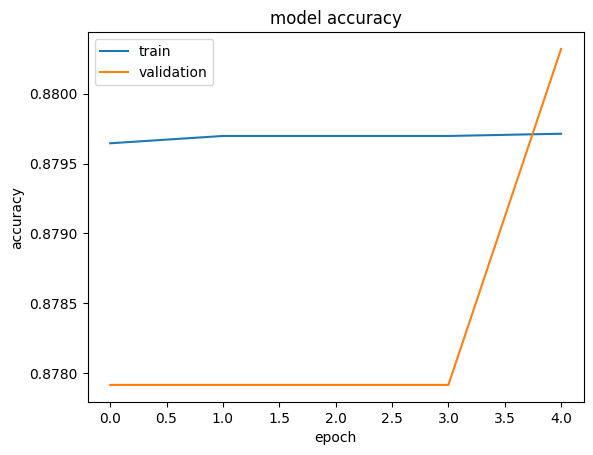

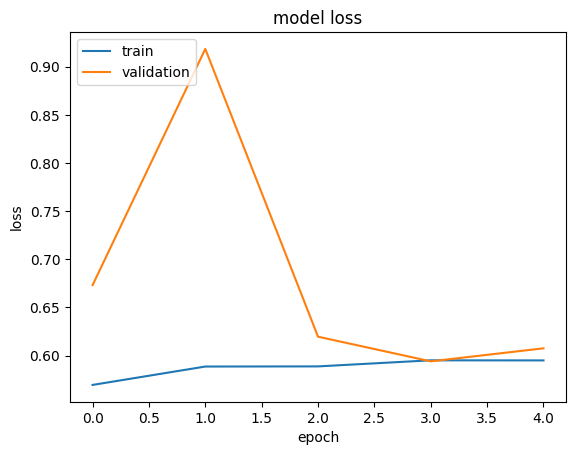

In [60]:
#  "Accuracy"
plt.plot(m1_b256_lr3.history['categorical_accuracy'])
plt.plot(m1_b256_lr3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_b256_lr3.history['loss'])
plt.plot(m1_b256_lr3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 1 batch = 128, lr = 1e-3, original data

In [61]:
m1_b128_lr3 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 86s 43ms/step - categorical_accuracy: 0.8800 - f1: 0.0727 - loss: 0.6196 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6349
Epoch 2/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 133s 40ms/step - categorical_accuracy: 0.8793 - f1: 0.0720 - loss: 0.6284 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6342
Epoch 3/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - categorical_accuracy: 0.8792 - f1: 0.0720 - loss: 0.6283 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6345
Epoch 4/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - categorical_accuracy: 0.8794 - f1: 0.0720 - loss: 0.6279 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 5/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - categorical_accuracy: 0.8801 - f1: 0.0720 - loss: 0.6251 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6341


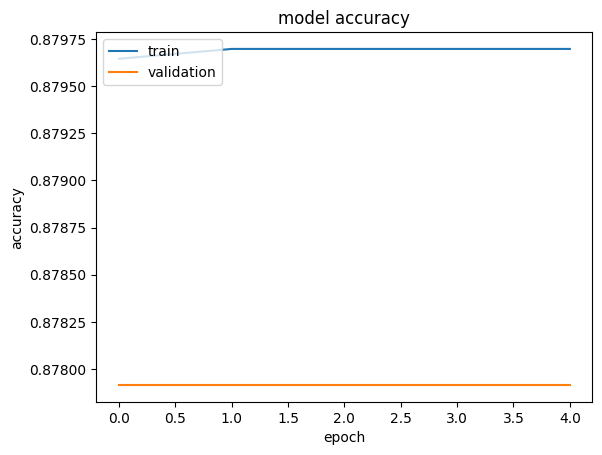

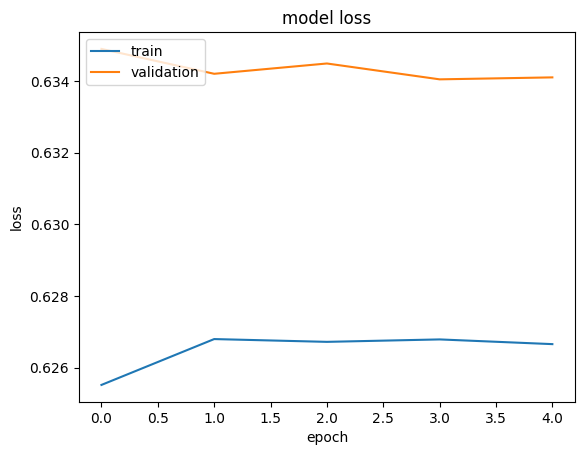

In [62]:
#  "Accuracy"
plt.plot(m1_b128_lr3.history['categorical_accuracy'])
plt.plot(m1_b128_lr3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_b128_lr3.history['loss'])
plt.plot(m1_b128_lr3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### LR = 1e-4

In [72]:
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 1 batch = 256, lr = 1e-4, original data

In [73]:
m1_b256_lr4 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 256,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 57s 54ms/step - categorical_accuracy: 0.8796 - f1: 0.0720 - loss: 0.6262 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 74s 48ms/step - categorical_accuracy: 0.8801 - f1: 0.0720 - loss: 0.6252 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - categorical_accuracy: 0.8798 - f1: 0.0720 - loss: 0.6258 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - categorical_accuracy: 0.8802 - f1: 0.0720 - loss: 0.6240 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 82s 48ms/step - categorical_accuracy: 0.8790 - f1: 0.0720 - loss: 0.6291 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340


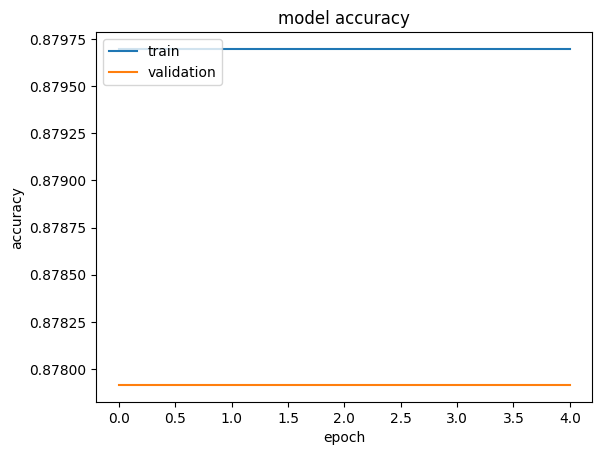

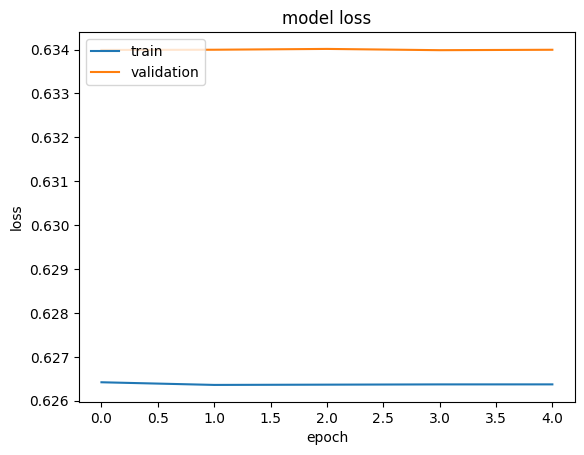

In [74]:
#  "Accuracy"
plt.plot(m1_b256_lr4.history['categorical_accuracy'])
plt.plot(m1_b256_lr4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_b256_lr4.history['loss'])
plt.plot(m1_b256_lr4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 1 batch = 128, lr = 1e-4, original data

In [75]:
m1_b128_lr4 = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 128,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 85s 42ms/step - categorical_accuracy: 0.8782 - f1: 0.0719 - loss: 0.6326 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 2/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 136s 40ms/step - categorical_accuracy: 0.8785 - f1: 0.0719 - loss: 0.6311 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 3/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - categorical_accuracy: 0.8796 - f1: 0.0720 - loss: 0.6272 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 4/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 81s 39ms/step - categorical_accuracy: 0.8798 - f1: 0.0720 - loss: 0.6255 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340
Epoch 5/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 82s 40ms/step - categorical_accuracy: 0.8799 - f1: 0.0720 - loss: 0.6254 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6340


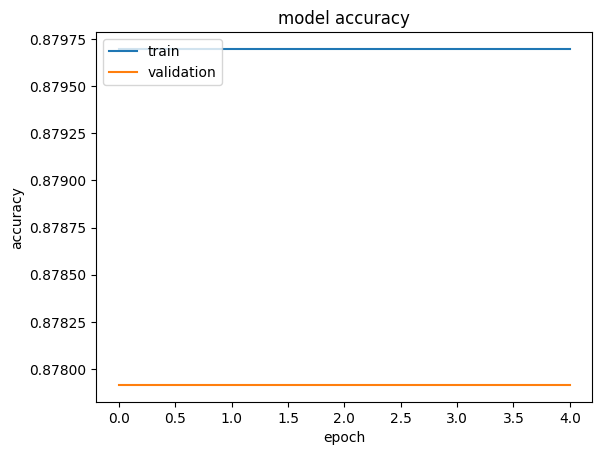

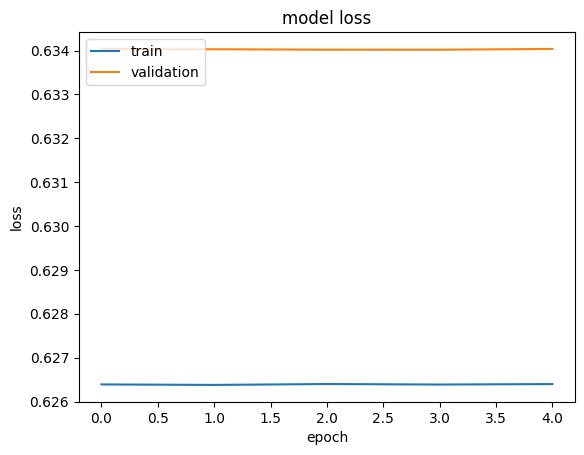

In [76]:
#  "Accuracy"
plt.plot(m1_b128_lr4.history['categorical_accuracy'])
plt.plot(m1_b128_lr4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_b128_lr4.history['loss'])
plt.plot(m1_b128_lr4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### RNN Model

In [63]:
model2 = keras.Sequential([
    keras.Input(shape=(None , 1)),
    keras.layers.SimpleRNN(128,activation = "tanh"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(13, activation="softmax")

])

In [64]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 128)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 13)                  │             845 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,741 (100.55 KB)

 Trainable params: 25,741 (100.55 KB)

 Non-trainable params: 0 (0.00 B)

#### LR = 1e-2

In [65]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 256, lr = 1e-2, original data

In [ ]:
m2_b256_lr2 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 404s 414ms/step - categorical_accuracy: 0.8678 - f1: 0.0743 - loss: 0.7111 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 2.0277
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 441s 413ms/step - categorical_accuracy: 0.8648 - f1: 0.0840 - loss: 1.4641 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6519
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 443s 415ms/step - categorical_accuracy: 0.8813 - f1: 0.0778 - loss: 0.6605 - val_categorical_accuracy: 0.8790 - val_f1: 0.0911 - val_loss: 0.6443
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 393s 405ms/step - categorical_accuracy: 0.8801 - f1: 0.0870 - loss: 0.6426 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6375
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 437s 400ms/step - categorical_accuracy: 0.8717 - f1: 0.0754 - loss: 1.5415 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6296


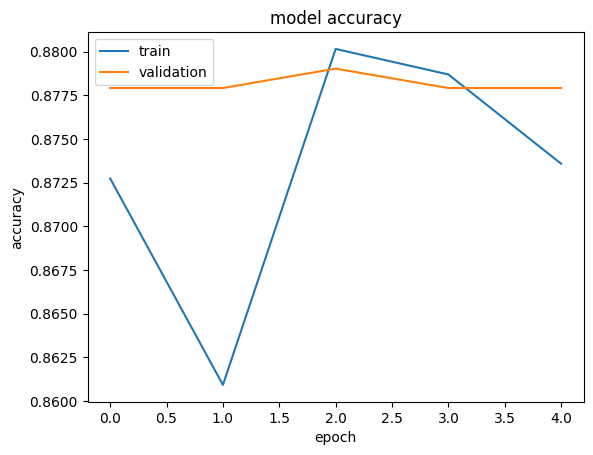

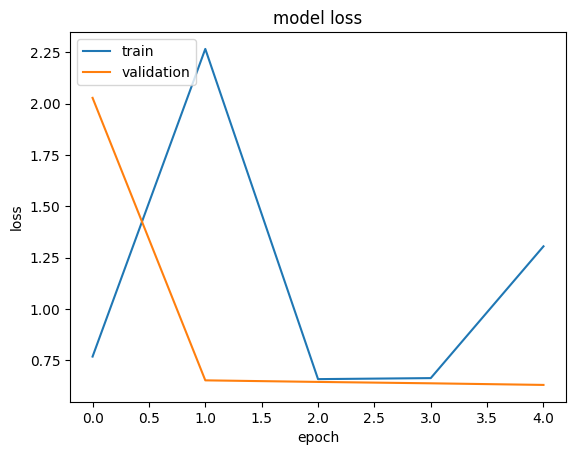

In [ ]:
#  "Accuracy"
plt.plot(m2_b256_lr2.history['categorical_accuracy'])
plt.plot(m2_b256_lr2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_b256_lr2.history['loss'])
plt.plot(m2_b256_lr2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 2 batch = 128, lr = 1e-2, original data

In [ ]:
m2_b128_lr2 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 256,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 406s 418ms/step - categorical_accuracy: 0.8810 - f1: 0.0725 - loss: 0.6149 - val_categorical_accuracy: 0.8780 - val_f1: 0.0733 - val_loss: 0.6256
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 429s 405ms/step - categorical_accuracy: 0.8697 - f1: 0.0739 - loss: 1.1423 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6326
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 399s 412ms/step - categorical_accuracy: 0.8800 - f1: 0.0752 - loss: 0.6213 - val_categorical_accuracy: 0.8784 - val_f1: 0.0768 - val_loss: 0.6243
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 433s 403ms/step - categorical_accuracy: 0.8797 - f1: 0.0806 - loss: 0.6211 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6339
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 451s 412ms/step - categorical_accuracy: 0.8797 - f1: 0.0720 - loss: 0.6257 - val_categorical_accuracy: 0.8779 - val_f1: 0.0719 - val_loss: 0.6208


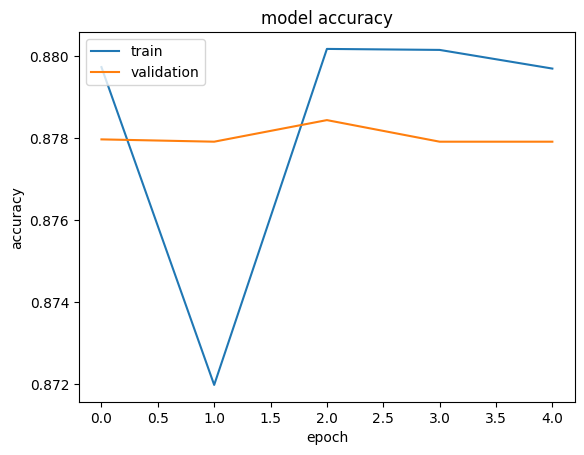

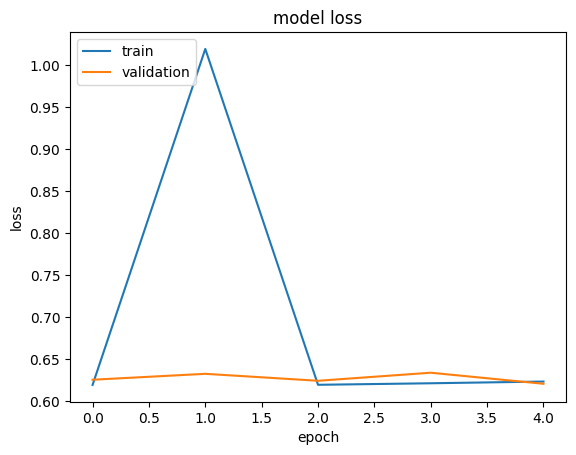

In [ ]:
#  "Accuracy"
plt.plot(m2_b128_lr2.history['categorical_accuracy'])
plt.plot(m2_b128_lr2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_b128_lr2.history['loss'])
plt.plot(m2_b128_lr2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### LR = 1e-3

In [77]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 256, lr = 1e-3, original data

In [69]:
m2_b256_lr3 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 256,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - categorical_accuracy: 0.8756 - f1: 0.1008 - loss: 0.5866 - val_categorical_accuracy: 0.9028 - val_f1: 0.1244 - val_loss: 0.2815
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - categorical_accuracy: 0.9020 - f1: 0.1407 - loss: 0.3037 - val_categorical_accuracy: 0.8823 - val_f1: 0.0937 - val_loss: 0.3531
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 50s 48ms/step - categorical_accuracy: 0.8919 - f1: 0.1182 - loss: 0.4036 - val_categorical_accuracy: 0.9025 - val_f1: 0.1266 - val_loss: 0.2784
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 74s 40ms/step - categorical_accuracy: 0.9034 - f1: 0.1408 - loss: 0.2761 - val_categorical_accuracy: 0.9032 - val_f1: 0.1466 - val_loss: 0.2745
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - categorical_accuracy: 0.9027 - f1: 0.1452 - loss: 0.2966 - val_categorical_accuracy: 0.9022 - val_f1: 0.1255 - val_loss: 0.2792


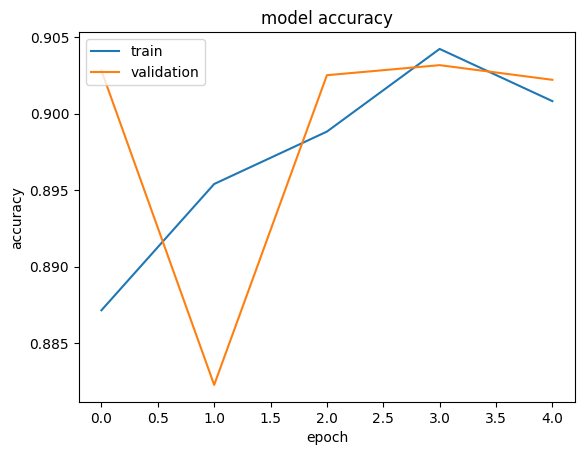

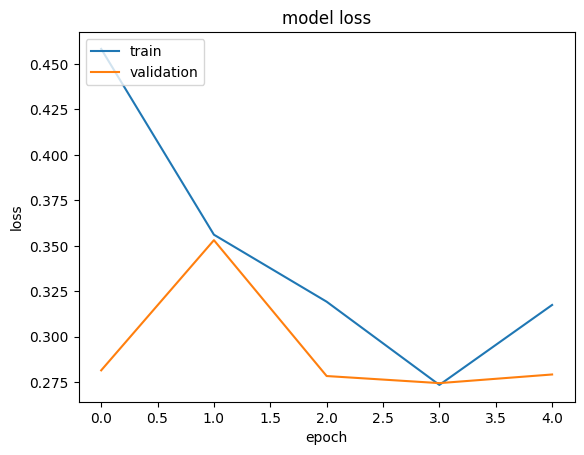

In [70]:
#  "Accuracy"
plt.plot(m2_b256_lr3.history['categorical_accuracy'])
plt.plot(m2_b256_lr3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_b256_lr3.history['loss'])
plt.plot(m2_b256_lr3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 2 batch = 128, lr = 1e-3, original data

In [ ]:
m2_b128_lr3 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - categorical_accuracy: 0.8829 - f1: 0.1142 - loss: 0.5064 - val_categorical_accuracy: 0.8797 - val_f1: 0.0904 - val_loss: 0.5214
Epoch 2/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 77s 37ms/step - categorical_accuracy: 0.8947 - f1: 0.1227 - loss: 0.3408 - val_categorical_accuracy: 0.8791 - val_f1: 0.0809 - val_loss: 0.5266
Epoch 3/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 80s 36ms/step - categorical_accuracy: 0.8917 - f1: 0.1152 - loss: 0.3668 - val_categorical_accuracy: 0.9017 - val_f1: 0.1143 - val_loss: 0.2813
Epoch 4/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 84s 38ms/step - categorical_accuracy: 0.8973 - f1: 0.1219 - loss: 0.3667 - val_categorical_accuracy: 0.9016 - val_f1: 0.1361 - val_loss: 0.2803
Epoch 5/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - categorical_accuracy: 0.9029 - f1: 0.1284 - loss: 0.2830 - val_categorical_accuracy: 0.9036 - val_f1: 0.1457 - val_loss: 0.2788


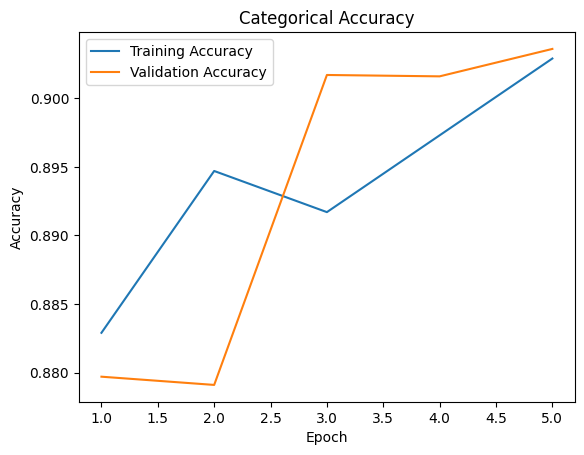

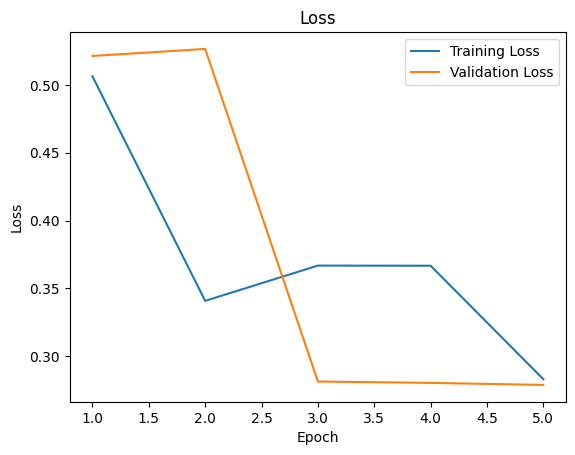

In [ ]:
# Data from the previous run
epochs = [1, 2, 3, 4, 5]
categorical_accuracy = [0.8829, 0.8947, 0.8917, 0.8973, 0.9029]
val_categorical_accuracy = [0.8797, 0.8791, 0.9017, 0.9016, 0.9036]
f1_score = [0.1142, 0.1227, 0.1152, 0.1219, 0.1284]
val_f1_score = [0.0904, 0.0809, 0.1143, 0.1361, 0.1457]
loss = [0.5064, 0.3408, 0.3668, 0.3667, 0.2830]
val_loss = [0.5214, 0.5266, 0.2813, 0.2803, 0.2788]


# Plot categorical accuracy
plt.plot(epochs, categorical_accuracy, label='Training Accuracy')
plt.plot(epochs, val_categorical_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.legend()
plt.show()

#Plot Loss
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

#### LR = 1e-4

In [78]:
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(), # from logits true or false?
        keras.metrics.F1Score(name="f1"), # F1 score is important because of target variable imbalance

    ],
)

##### Model 2 batch = 256, lr = 1e-4, original data

In [79]:
m2_b256_lr4 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 38s 37ms/step - categorical_accuracy: 0.9045 - f1: 0.1348 - loss: 0.2729 - val_categorical_accuracy: 0.9044 - val_f1: 0.1520 - val_loss: 0.2718
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - categorical_accuracy: 0.9048 - f1: 0.1514 - loss: 0.2710 - val_categorical_accuracy: 0.9044 - val_f1: 0.1593 - val_loss: 0.2709
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - categorical_accuracy: 0.9055 - f1: 0.1529 - loss: 0.2675 - val_categorical_accuracy: 0.9048 - val_f1: 0.1607 - val_loss: 0.2699
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - categorical_accuracy: 0.9062 - f1: 0.1531 - loss: 0.2657 - val_categorical_accuracy: 0.9050 - val_f1: 0.1609 - val_loss: 0.2692
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 34s 35ms/step - categorical_accuracy: 0.9060 - f1: 0.1535 - loss: 0.2650 - val_categorical_accuracy: 0.9052 - val_f1: 0.1627 - val_loss: 0.2688


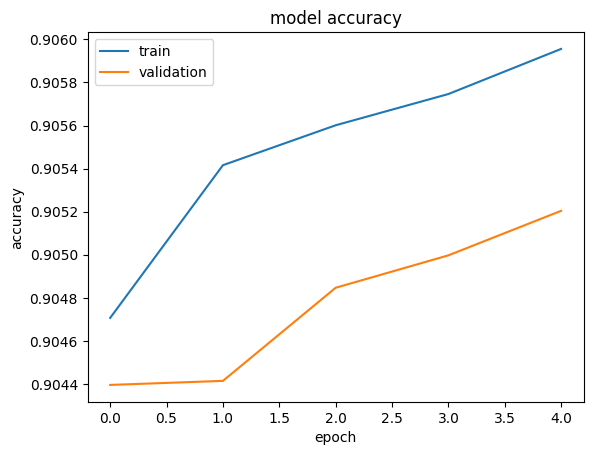

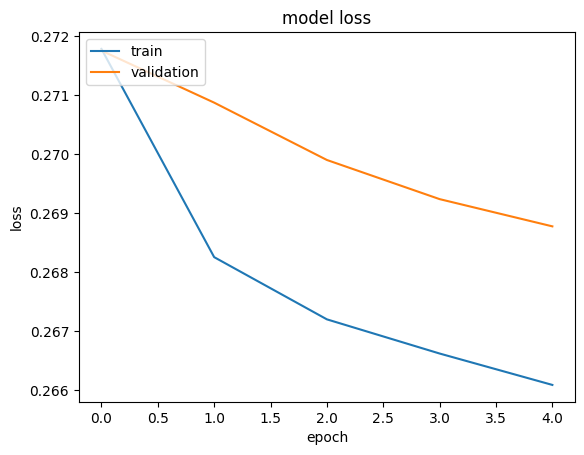

In [81]:
#  "Accuracy"
plt.plot(m2_b256_lr4.history['categorical_accuracy'])
plt.plot(m2_b256_lr4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_b256_lr4.history['loss'])
plt.plot(m2_b256_lr4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##### Model 2 batch = 128, lr = 1e-4, original data

In [80]:
m2_b128_lr4 = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val) #,
      #class_weight = class_weight_dict
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 48s 49ms/step - categorical_accuracy: 0.9060 - f1: 0.1531 - loss: 0.2649 - val_categorical_accuracy: 0.9051 - val_f1: 0.1601 - val_loss: 0.2689
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 68s 35ms/step - categorical_accuracy: 0.9054 - f1: 0.1541 - loss: 0.2678 - val_categorical_accuracy: 0.9052 - val_f1: 0.1604 - val_loss: 0.2685
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - categorical_accuracy: 0.9057 - f1: 0.1558 - loss: 0.2658 - val_categorical_accuracy: 0.9052 - val_f1: 0.1591 - val_loss: 0.2682
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - categorical_accuracy: 0.9061 - f1: 0.1554 - loss: 0.2654 - val_categorical_accuracy: 0.9043 - val_f1: 0.1547 - val_loss: 0.2699
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step - categorical_accuracy: 0.9053 - f1: 0.1544 - loss: 0.2664 - val_categorical_accuracy: 0.9054 - val_f1: 0.1627 - val_loss: 0.2680


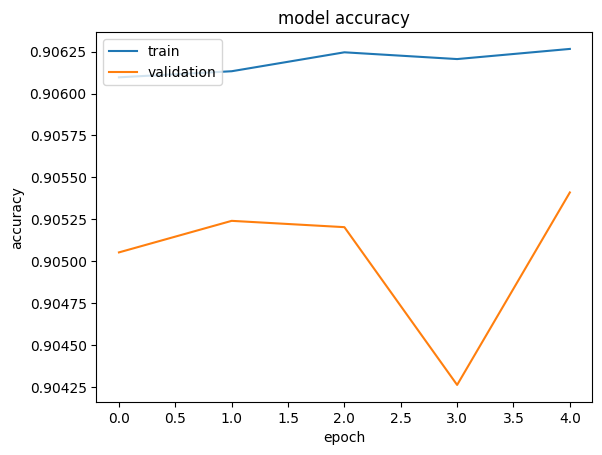

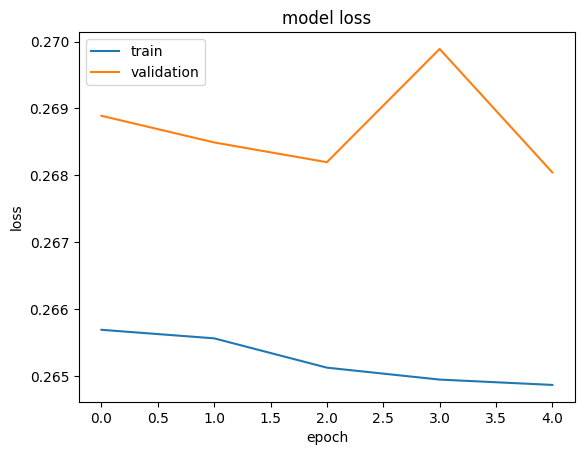

In [82]:
#  "Accuracy"
plt.plot(m2_b128_lr4.history['categorical_accuracy'])
plt.plot(m2_b128_lr4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m2_b128_lr4.history['loss'])
plt.plot(m2_b128_lr4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Class Weights

In [ ]:
# Flatten y_train to a 1D array
y_train_flat = y_train.flatten()

# Calculate unique classes
unique_classes = np.unique(y_train_flat)

# Compute class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_flat)

# Create a dictionary mapping class labels to their weights
class_weight_dict = dict(zip(unique_classes, class_weights))

In [ ]:
m1_ori_cw_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= 256,
      epochs= 5,
      validation_data=(X_val_pretensor, y_val),
      class_weight = class_weight_dict,
      callbacks=[WandbMetricsLogger()]
    )

Epoch 1/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1222s 1s/step - categorical_accuracy: 0.8718 - f1_score: 0.0726 - loss: 0.8482 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6494
Epoch 2/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1214s 1s/step - categorical_accuracy: 0.8789 - f1_score: 0.0720 - loss: 0.7369 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6631
Epoch 3/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1213s 1s/step - categorical_accuracy: 0.8800 - f1_score: 0.0720 - loss: 0.7260 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6874
Epoch 4/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1208s 1s/step - categorical_accuracy: 0.8796 - f1_score: 0.0720 - loss: 0.7489 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6701
Epoch 5/5
970/970 ━━━━━━━━━━━━━━━━━━━━ 1215s 1s/step - categorical_accuracy: 0.8805 - f1_score: 0.0720 - loss: 0.7431 - val_categorical_accuracy: 0.8779 - val_f1_score: 0.0719 - val_loss: 0.6741


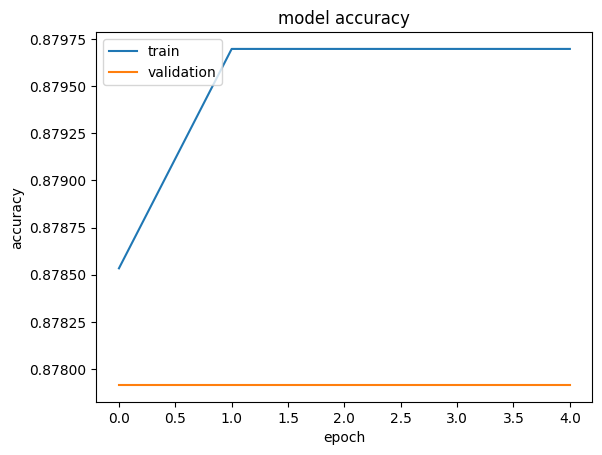

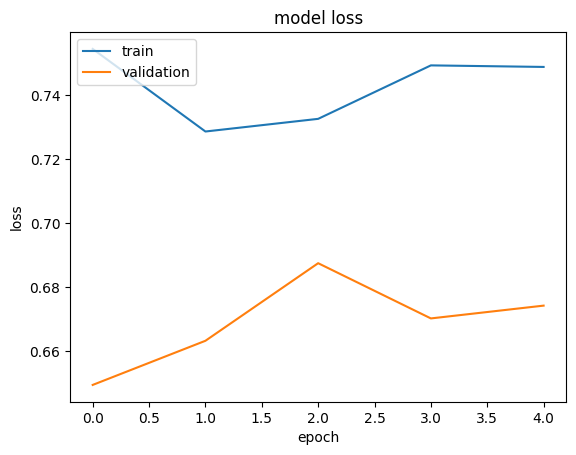

In [ ]:
#  "Accuracy"
plt.plot(m1_ori_cw_his.history['categorical_accuracy'])
plt.plot(m1_ori_cw_his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(m1_ori_cw_his.history['loss'])
plt.plot(m1_ori_cw_his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
m2_ori_cw_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      class_weight = class_weight_dict
    )

Epoch 1/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - categorical_accuracy: 0.8780 - f1: 0.1018 - loss: 0.5395 - val_categorical_accuracy: 0.8853 - val_f1: 0.1073 - val_loss: 0.2955
Epoch 2/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - categorical_accuracy: 0.8853 - f1: 0.1147 - loss: 0.3730 - val_categorical_accuracy: 0.9018 - val_f1: 0.1230 - val_loss: 0.2890
Epoch 3/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 78s 37ms/step - categorical_accuracy: 0.8899 - f1: 0.1286 - loss: 0.3302 - val_categorical_accuracy: 0.8804 - val_f1: 0.0907 - val_loss: 0.4534
Epoch 4/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - categorical_accuracy: 0.8874 - f1: 0.1200 - loss: 0.3501 - val_categorical_accuracy: 0.8870 - val_f1: 0.1267 - val_loss: 0.2990
Epoch 5/5
1940/1940 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - categorical_accuracy: 0.8889 - f1: 0.1228 - loss: 0.3286 - val_categorical_accuracy: 0.8874 - val_f1: 0.1278 - val_loss: 0.2944


### Resample

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to generate synthetic samples
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pretensor, y_train)

In [ ]:
m1_rs_his = model1.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= 256,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val)
    )

In [ ]:
m2_rs_his = model2.fit(
      x= X_train_resampled,
      y= y_train_resampled,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val)
    )

### Learning Rate Scheduler

In [ ]:
def scheduler(epoch, lr):
     if epoch < 10:
         return lr
     else:
         return lr * tf.math.exp(-0.1).numpy()
callback = keras.callbacks.LearningRateScheduler(scheduler)
# in model.fit callback = callback

In [83]:
m1_ori_sched_his = model1.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      #class_weight = class_weight_dict,
      callbacks = callback
    )

NameError: name 'callback' is not defined

In [84]:
m2_ori_sched_his = model2.fit(
      x= X_train_pretensor,
      y= y_train,
      batch_size= batch_size,
      epochs= n_epochs,
      validation_data=(X_val_pretensor, y_val),
      #class_weight = class_weight_dict,
      callbacks = callback
    )

NameError: name 'callback' is not defined

### Testing models

In [66]:
loss, accuracy, f1 = model1.evaluate(X_test_pretensor, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1:", np.mean(f1))

1663/1663 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - categorical_accuracy: 0.8813 - f1: 0.0721 - loss: 0.6197
Test Loss: 0.6256762146949768
Test Accuracy: 0.8795151114463806
Test F1: 0.07199197


In [71]:
loss, accuracy, f1 = model2.evaluate(X_test_pretensor, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test F1:", np.mean(f1))

1663/1663 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - categorical_accuracy: 0.9055 - f1: 0.1278 - loss: 0.2711
Test Loss: 0.27453920245170593
Test Accuracy: 0.9047735333442688
Test F1: 0.1287553
